# Fully Connected QNN VS CNN

In [ ]:
!pip3 install --upgrade pip
!pip3 install tensorflow==2.7.0
!pip3 install -U tensorflow-quantum 
!pip3 install seaborn matplotlib

!pip3 install googleapis-common-protos==1.52.0 google-api-core==1.21.0 google-auth==1.18.0 google-api-python-client==1.8.0 grpcio==1.34.1 protobuf==3.17.3

  Obtaining dependency information for MarkupSafe>=2.1.1 from https://files.pythonhosted.org/packages/de/e2/32c14301bb023986dff527a49325b6259cab4ebb4633f69de54af312fc45/MarkupSafe-2.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached MarkupSafe-2.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
Using cached MarkupSafe-2.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.8/py-core/lib/python3.8/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.


In [ ]:
#!pip3 install cirq-core==0.13.1 cirq-google==0.13.1 sympy==1.8 numpy==1.19.5 nbformat==4.4.0 pylint==2.4.4 yapf==0.28.0 tensorflow==2.7.0 googleapis-common-protos==1.52.0 google-api-core==1.21.0 google-auth==1.18.0 google-api-python-client==1.8.0 grpcio==1.34.1 protobuf==3.17.3 

In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/root/venv/lib/python3.8/site-packages/pkg_resources/__init__.py'>

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


2023-08-22 15:41:06.460296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-22 15:41:06.460345: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-22 15:41:14.625410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-22 15:41:14.625457: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-22 15:41:14.625481: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-4029068e-263e-4c12-9932-d3ac72036324): /proc/driver/nvidia/version does not exist
2023-08-22 15:41:14.627202: I tensorfl

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


11501568/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
def filter_48(x, y):
    keep = (y == 4) | (y == 8)
    x, y = x[keep], y[keep]
    y = y == 4
    return x,y


In [ ]:
x_train, y_train = filter_48(x_train, y_train)
x_test, y_test = filter_48(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))


Number of filtered training examples: 11693
Number of filtered test examples: 1956


True


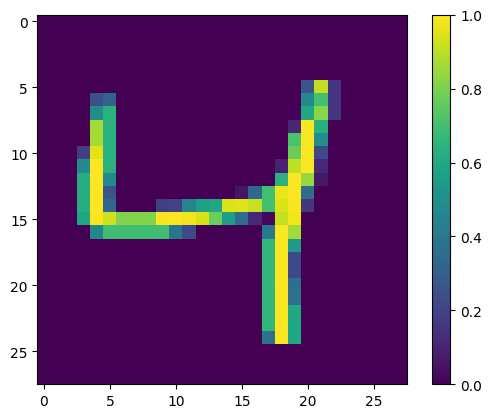

In [ ]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()


In [ ]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


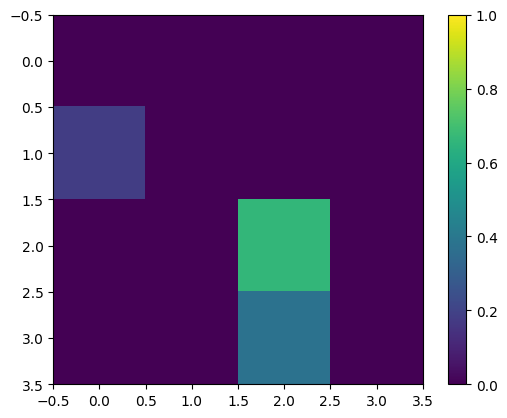

In [ ]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()


In [ ]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
        orig_x[tuple(x.flatten())] = x
        mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
        x = orig_x[flatten_x]
        labels = mapping[flatten_x]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(next(iter(labels)))
        else:
            # Throw out images that match more than one label.
            pass

    num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_8 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_4)
    print("Number of unique 6s: ", num_uniq_8)
    print("Number of unique contradicting labels (both 4 and 8): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)


In [ ]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10964
Number of unique 3s:  5320
Number of unique 6s:  5508
Number of unique contradicting labels (both 4 and 8):  136

Initial number of images:  11693
Remaining non-contradicting unique images:  10828


In [ ]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [ ]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 165
Number of unique 3s:  33
Number of unique 6s:  57
Number of unique contradicting labels (both 4 and 8):  75

Initial number of images:  10828
Remaining non-contradicting unique images:  90


In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


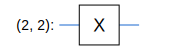

In [ ]:
SVGCircuit(x_train_circ[0])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


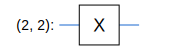

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2]])

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


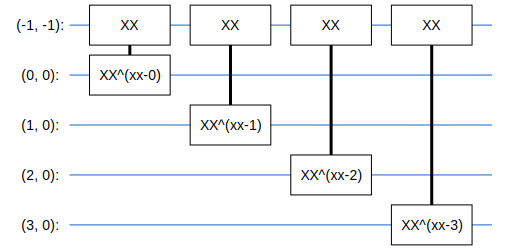

In [ ]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)


In [ ]:
model_circuit, model_readout = create_quantum_model()

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
339/339 [==============================] - 844s 2s/step - loss: 0.9900 - hinge_accuracy: 0.5269 - val_loss: 0.9412 - val_hinge_accuracy: 0.5615
Epoch 2/3
339/339 [==============================] - 841s 2s/step - loss: 0.8509 - hinge_accuracy: 0.6091 - val_loss: 0.8572 - val_hinge_accuracy: 0.5953
Epoch 3/3
62/62 [==============================] - 23s 372ms/step - loss: 0.8160 - hinge_accuracy: 0.6290


In [ ]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                      

In [ ]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 2s 24ms/step - loss: 0.0135 - accuracy: 0.9964


In [ ]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)


Epoch 1/20
85/85 - 1s - loss: 0.6959 - accuracy: 0.5087 - val_loss: 0.7025 - val_accuracy: 0.4980 - 646ms/epoch - 8ms/step
Epoch 2/20
85/85 - 0s - loss: 0.6834 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.5010 - 213ms/epoch - 3ms/step
Epoch 3/20
85/85 - 0s - loss: 0.6740 - accuracy: 0.5183 - val_loss: 0.6858 - val_accuracy: 0.5143 - 181ms/epoch - 2ms/step
Epoch 4/20
85/85 - 0s - loss: 0.6647 - accuracy: 0.5281 - val_loss: 0.6779 - val_accuracy: 0.5189 - 131ms/epoch - 2ms/step
Epoch 5/20
85/85 - 0s - loss: 0.6545 - accuracy: 0.5307 - val_loss: 0.6702 - val_accuracy: 0.5204 - 231ms/epoch - 3ms/step
Epoch 6/20
85/85 - 0s - loss: 0.6447 - accuracy: 0.5323 - val_loss: 0.6633 - val_accuracy: 0.5174 - 164ms/epoch - 2ms/step
Epoch 7/20
85/85 - 0s - loss: 0.6365 - accuracy: 0.5384 - val_loss: 0.6582 - val_accuracy: 0.5215 - 272ms/epoch - 3ms/step
Epoch 8/20
85/85 - 0s - loss: 0.6307 - accuracy: 0.5663 - val_loss: 0.6546 - val_accuracy: 0.5588 - 141ms/epoch - 2ms/step
Epoch 9/20
85/85

<AxesSubplot: >

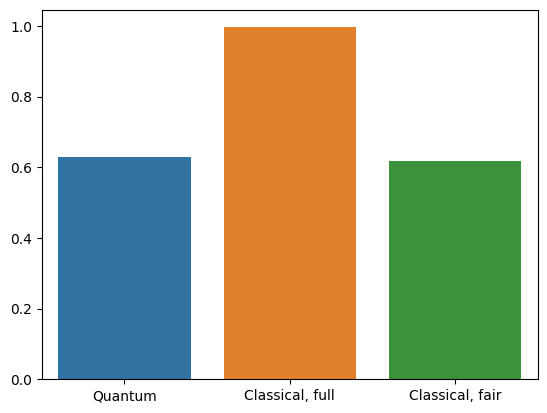

In [ ]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(x=["Quantum", "Classical, full", "Classical, fair"],
            y=[qnn_accuracy, cnn_accuracy, fair_nn_accuracy])


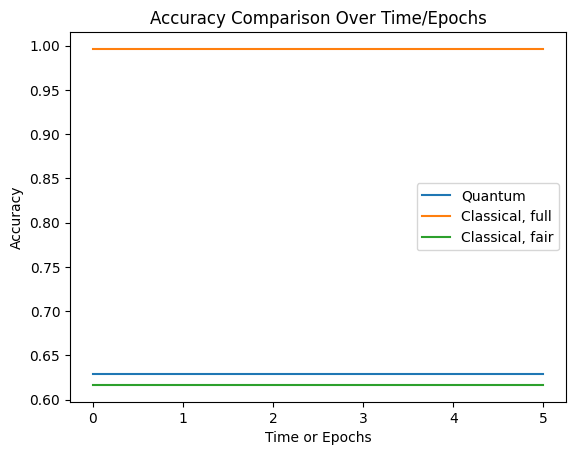

In [ ]:
time_points = [0, 1, 2, 3, 4, 5]
qnn_accuracy = qnn_results[1]  # Assuming qnn_results contains [loss, accuracy] for each time point
cnn_accuracy = cnn_results[1]  # Assuming cnn_results contains [loss, accuracy] for each time point
fair_nn_accuracy = fair_nn_results[1]  # Assuming fair_nn_results contains [loss, accuracy] for each time point

# Create a line plot
sns.lineplot(x=time_points, y=qnn_accuracy, label='Quantum')
sns.lineplot(x=time_points, y=cnn_accuracy, label='Classical, full')
sns.lineplot(x=time_points, y=fair_nn_accuracy, label='Classical, fair')

# Set plot labels and title
plt.xlabel('Time or Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Over Time/Epochs')

# Add a legend
plt.legend()

# Show the plot
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4029068e-263e-4c12-9932-d3ac72036324' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>